# Task 2 - QOSF Mentorship Program

In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile, assemble, IBMQ, execute
from qiskit.circuit.library import RealAmplitudes, TwoLocal
from qiskit.visualization import plot_histogram
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import PauliFeatureMap, ZZFeatureMap
from qiskit.opflow import Gradient, NaturalGradient, PauliExpectation, CircuitSampler
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit.algorithms.optimizers import GradientDescent, SPSA, QNSPSA
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier, VQC, QGAN, QSVC
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel
from IPython.display import display, Math, Latex
from math import pi, log
import random
import time
import datetime
from qiskit.circuit.library import ZZFeatureMap
from qiskit.opflow import Z, X, Y, I, StateFn
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.datasets import ad_hoc_data

### Prepare 4 random 4-qubit quantum states of your choice

In [2]:
backend = Aer.get_backend('qasm_simulator')
q_instance = QuantumInstance(backend, shots = 1024, seed_simulator = 2718, seed_transpiler = 2718)
n = 4 # 4 qubits

### Create and train a variational circuit that transforms input states into predefined output states

In [4]:
states = {
    0: '0011',
    1: '0101',
    2: '1010',
    3: '1100'
}

In [5]:
def random_states():
    states = []
    str_inp_states = []
    
    while len(states) < 4:
        qc = QuantumCircuit(4)
        qc.h(range(4))
        qc.measure_all()
        sim = Aer.get_backend('statevector_simulator')
        input_state = list(sim.run(assemble(qc)).result().get_counts())[0]
        if input_state not in str_inp_states:
            output_state = len(states)
            str_inp_states.append(input_state)
            states.append([[int(x) for x in list(input_state)], [output_state]])
            
    a = []
    for s in states:
        a0 = s[0]
        for a1 in s[1]:
            a0.append(a1)
        a.append(a0)
    
    return a

In [6]:
training_states = random_states()
training_states

/opt/conda/lib/python3.8/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


[[1, 0, 1, 0, 0], [1, 0, 1, 1, 1], [0, 0, 1, 1, 2], [0, 0, 0, 0, 3]]

In [7]:
training_input_states = [''.join([str(x) for x in i[:4]]) for i in training_states]

In [8]:
df = pd.DataFrame({})
for i in range(200):
    choice = np.array(training_states[np.random.randint(0, 4)])
    df = df.append([choice.ravel().tolist()], ignore_index=True)
df.columns = ['x0', 'x1', 'x2', 'x3', 'y']

In [9]:
df.head()

,x0,x1,x2,x3,y
0,1,0,1,1,1
1,1,0,1,0,0
2,0,0,1,1,2
3,0,0,1,1,2
4,0,0,0,0,3


In [10]:
features = ['x0', 'x1', 'x2', 'x3']
target = 'y'
X_train, X_test, y_train, y_test = train_test_split(df[features].to_numpy(), df[target].to_numpy(), test_size=0.2)

### The variational circuit

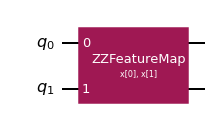

In [11]:
dim = 2
feature_map = ZZFeatureMap(dim, reps=1)  # let's keep it simple!
feature_map.draw('mpl', style='iqx')

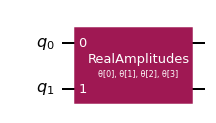

In [12]:
ansatz = RealAmplitudes(num_qubits=dim, entanglement='linear', reps=1)  # also simple here!
ansatz.draw('mpl', style='iqx')

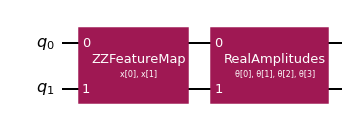

In [13]:
circuit = feature_map.compose(ansatz)
circuit.draw('mpl', style='iqx')

In [14]:
hamiltonian = Z ^ Z  # global Z operators

In [15]:
training_features, training_labels, test_features, test_labels = ad_hoc_data(
    training_size=20, test_size=10, n=2, one_hot=False, gap=0.5
)

# the training labels are in {0, 1} but we'll use {-1, 1} as class labels!
training_labels = 2 * training_labels - 1
test_labels = 2 * test_labels - 1

In [ ]:
gd_qnn_loss = []
def gd_qnn_callback(*args):
    gd_qnn_loss.append(args[2])
    
gd = GradientDescent(maxiter=100, learning_rate=0.01, callback=gd_qnn_callback)
from qiskit_machine_learning.neural_networks import OpflowQNN

qnn_expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)
qnn = OpflowQNN(qnn_expectation, 
                input_params=list(feature_map.parameters), 
                weight_params=list(ansatz.parameters),
                exp_val=PauliExpectation(),
                gradient=Gradient(),  # <-- Parameter-Shift gradients
                quantum_instance=q_instance)
classifier = NeuralNetworkClassifier(qnn, optimizer=gd)
classifier.fit(training_features, training_labels);
predicted = classifier.predict(test_features)

In [ ]:
def plot_predicted():
    from matplotlib.lines import Line2D
    plt.figure(figsize=(12, 6))

    for feature, label in zip(training_features, training_labels):
        marker = 'o' 
        color = 'tab:green' if label == -1 else 'tab:blue'
        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    for feature, label, pred in zip(test_features, test_labels, predicted):
        marker = 's' 
        color = 'tab:green' if pred == -1 else 'tab:blue'
        if label != pred:  # mark wrongly classified
            plt.scatter(feature[0], feature[1], marker='o', s=500, linewidths=2.5,
                        facecolor='none', edgecolor='tab:red')

        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    legend_elements = [
        Line2D([0], [0], marker='o', c='w', mfc='tab:green', label='A', ms=15),
        Line2D([0], [0], marker='o', c='w', mfc='tab:blue', label='B', ms=15),
        Line2D([0], [0], marker='s', c='w', mfc='tab:green', label='predict A', ms=10),
        Line2D([0], [0], marker='s', c='w', mfc='tab:blue', label='predict B', ms=10),
        Line2D([0], [0], marker='o', c='w', mfc='none', mec='tab:red', label='wrongly classified', mew=2, ms=15)
    ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.7))
    
    plt.title('Training & test data')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    
plot_predicted()

In [ ]:
qng_qnn_loss = []
def qng_qnn_callback(*args):
    qng_qnn_loss.append(args[2])
    
gd = GradientDescent(maxiter=100, learning_rate=0.01, callback=qng_qnn_callback)
qnn = OpflowQNN(qnn_expectation, 
                input_params=list(feature_map.parameters), 
                weight_params=list(ansatz.parameters),
                gradient=NaturalGradient(regularization='ridge'),  # <-- using Natural Gradients!
                quantum_instance=q_instance)
classifier = NeuralNetworkClassifier(qnn, optimizer=gd)#, initial_point=initial_point)
classifier.fit(training_features, training_labels);


In [ ]:
def plot_losses():

    plt.figure(figsize=(12, 6))
    plt.plot(gd_qnn_loss, 'tab:blue', marker='o', label='vanilla gradients')
    plt.plot(qng_qnn_loss, 'tab:green', marker='o', label='natural gradients')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend(loc='best')

plot_losses()